In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [4]:
#Import the data
df = pd.read_csv('../Data/Amp_data/allele_counts_anon.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1])
df['tot_reads'] = df['MT'] + df ['WT']
df['Plate'] = df.index.get_level_values(1)
df['Well'] = df.index.get_level_values(0)
df['Amplicon'] = df.index.get_level_values(2)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two', 'MT', 'WT'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Add in and standardise cell types
df['celltype'] = df['Plate'].replace(plate_cell_dict)
rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34', 'NEs':'Neut', 'Monocytes': 'Mono', 'nBCs': 'nBC'}
df['celltype'].replace(rename, inplace = True) #df now contains cell type as well, standardised for all plates
amplicons = df['Amplicon'].drop_duplicates().to_list()
ctypes = ['CD34', 'Mono', 'Neut', 'nBC']
df.set_index(['Plate', 'Well','celltype', 'Amplicon'], inplace = True)
patients = df['Patient'].drop_duplicates().to_list()


#Split into single plottable df for each patient
all_df = {}
for pt in patients:
    df2 = df.loc[df['Patient'].isin([pt])]
    df2 = df2.drop(columns = 'Patient')
    df2 = df2.unstack(3)
    cols = list(df2.columns.get_level_values(level=1))
    df2.columns = cols
    all_df[pt] = df2
    
all_df['JP001']    

JP001_RUNX1_c  JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a  \
Plate  Well celltype                                                           
AS-187 A1   Mono                3.0           88.0         12.0        144.0   
       A10  Mono                1.0            3.0          3.0          0.0   
       A11  Mono                1.0            3.0        389.0          3.0   
       A12  Mono               14.0          129.0         24.0         20.0   
       A13  Mono               27.0          136.0         17.0         29.0   
...                             ...            ...          ...          ...   
AS-201 P5   CD34                0.0            0.0          2.0          0.0   
       P6   CD34               29.0           13.0          5.0          6.0   
       P7   CD34                9.0            4.0          2.0          3.0   
       P8   CD34               52.0           23.0          9.0          7.0   
       P9   CD34               44.0           19.0          3.0          5.0   

                      JP001_TET2b_c  JP001_TET2b_g  
Plate  Well celltype                                
AS-187 A1   Mono                NaN            0.0  
       A10  Mono                NaN            0.0  
       A11  Mono                NaN            0.0  
       A12  Mono                NaN            0.0  
       A13  Mono                NaN            0.0  
...                             ...            ...  
AS-201 P5   CD34                NaN            0.0  
       P6   CD34                NaN            0.0  
       P7   CD34                NaN            0.0  
       P8   CD34                NaN            0.0  
       P9   CD34                NaN            0.0  

[3456 rows x 6 columns]

In [5]:
#Make sub-list of amplicons to plot
amps = []
for a in amplicons:
    if a in ['JP001_RUNX1_c','JP001_TET2b_c','PD7153_TGFB3_c','PD7153_CUX1']:
        continue  
    else:
        amps.append(a) 

Text(0.5, 0.98, 'Cells with >x reads for each amplicon')

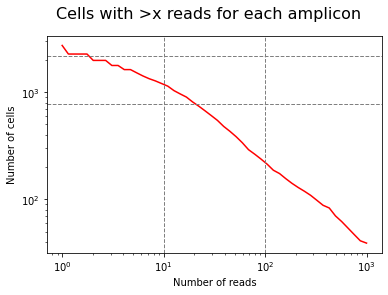

In [6]:
#Make some plots
plot_df = all_df['PD7151'] 
x = np.logspace(0, 3, 50) 
y = [plot_df.loc[(plot_df >= xi).all(axis=1)].shape[0] for xi in x]

fig, ax = plt.subplots()

ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(10, ls = '--', lw = 1, color = 'gray')
ax.axvline(100, ls = '--', lw = 1, color = 'gray')
ax.axhline(2200, ls = '--', lw = 1, color = 'gray')
ax.axhline(780, ls = '--', lw = 1, color = 'gray')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Number of cells')
fig.suptitle('Cells with >x reads for each amplicon', fontsize=16)  

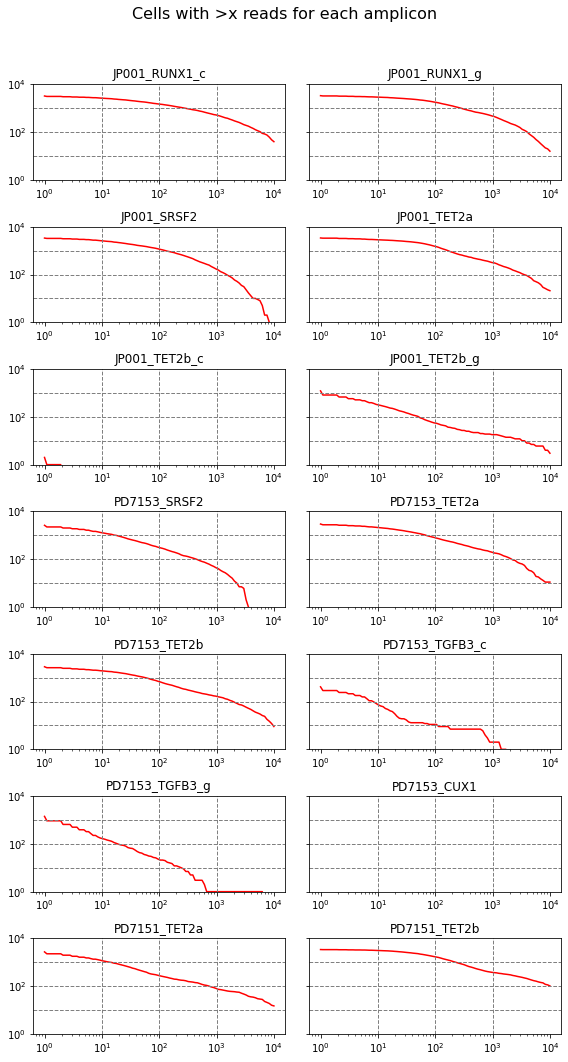

In [7]:
#Plot all amplicons
fig, ax = plt.subplots(int(len(amplicons)/2), 2, figsize = (8, 14), gridspec_kw = dict(height_ratios = [1, 1, 1, 1, 1, 1, 1]),  sharey = True) 

ax = ax.ravel()

for i, a in enumerate(amplicons):
    p = a.split('_')[0]
    plot_df = all_df[p].copy() 
    x = np.logspace(0, 4, 100) 
    y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
    ax[i].plot(x, y, color = 'red')
    
    if i != [8, 9]:
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('reads')
        
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    #ax[i].set_xlim(1, 10000)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].set_title(f'{a}')  

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

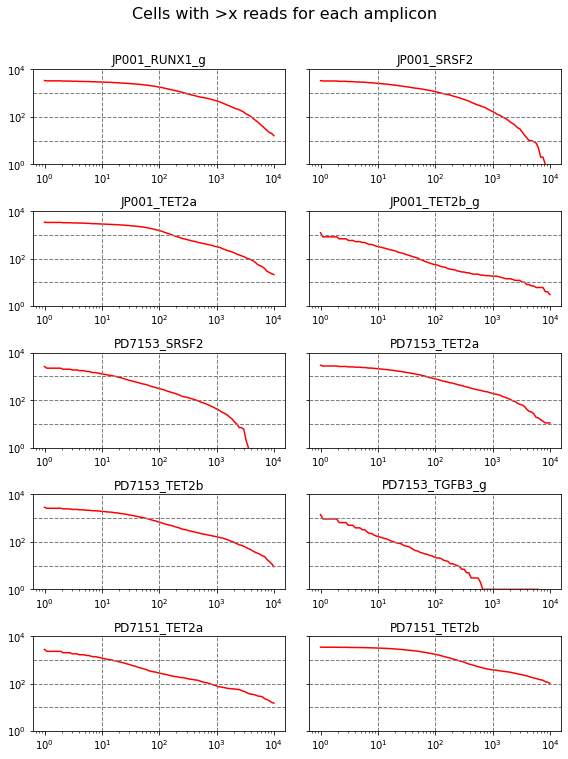

In [8]:
#Plot all useful amplicons
fig, ax = plt.subplots(int(len(amps)/2), 2, figsize = (8, 10), gridspec_kw = dict(height_ratios = [1, 1, 1, 1, 1]),  sharey = True) 

ax = ax.ravel()

for i, a in enumerate(amps):
    p = a.split('_')[0]
    plot_df = all_df[p].copy() 
    x = np.logspace(0, 4, 100) 
    y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
    ax[i].plot(x, y, color = 'red')
    
    if i != [8, 9]:
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('reads')
        
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    #ax[i].set_xlim(1, 10000)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].set_title(f'{a}')  

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

In [9]:
#Colour palettes
all_amps = ['PD7153_TET2a',
            'PD7151_TET2a',
            'JP001_TET2a',
            'PD7153_TET2b',
            'PD7151_TET2b',
            'JP001_TET2b_g',
            'PD7153_SRSF2',
            'PD7151_SRSF2',
            'JP001_SRSF2',
            'PD7153_CUX1',
            'JP001_RUNX1_g'
           ]
short_label = ['TET2[a]',
               'TET2[a]',
               'TET2[a]',
               'TET2[b]',
               'TET2[b]',
               'TET2[b]',
               'SRSF2',
               'SRSF2',
               'SRSF2',
               'CUX1',
               'RUNX1'
              ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

['JP001_TET2a', 'JP001_TET2b_g', 'JP001_SRSF2', 'JP001_RUNX1_g']
['PD7153_TET2a', 'PD7153_TET2b', 'PD7153_SRSF2']
['PD7151_TET2a', 'PD7151_TET2b']


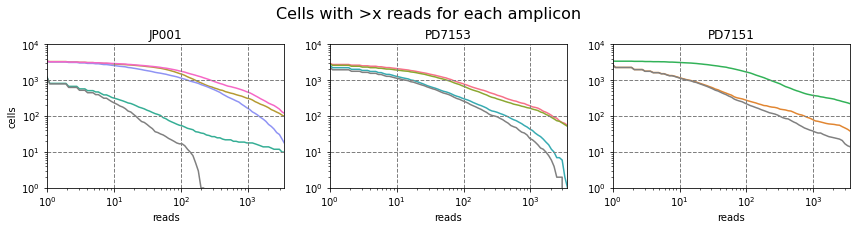

In [10]:
#Plot amplicons for each patient on single plot - match colors to VAF plots
fig, ax = plt.subplots(1, 3, figsize = (12, 3)) 

ax = ax.ravel()

for i, p in enumerate(patients):
    plot_df = all_df[p].copy()
    c = plot_df.columns
    d = []
    for a in all_amps:
        if a not in c:
            continue
        else:
            x = np.logspace(0, 4, 100) 
            y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
            ax[i].plot(x, y, color = allVAFcols[a])
            if a != 'PD7153_CUX1':
                d.append(a)
    print(d)
    
    allplot = plot_df[d]
    
    x = np.logspace(0, 4, 100)     
    y = [allplot.loc[(allplot >= xi).all(axis=1)].shape[0] for xi in x]
    ax[i].plot(x, y, color = 'gray')
    
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    ax[i].set_xlim(1, 3500)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].set_xlabel('reads') 
    ax[0].set_ylabel('cells') 
    
    ax[i].set_title(f'{p}')  

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

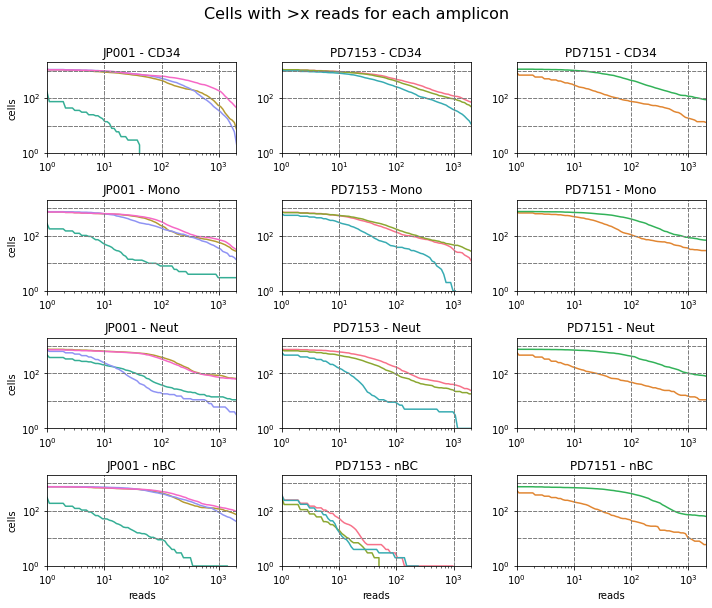

In [11]:
#Plot amplicons for each patient on single plot by cell type - match colors to VAF plots
fig, ax = plt.subplots(4, 3, figsize = (10, 8)) 

ax = ax.ravel()

for l, p in enumerate(patients):
    plot_df2 = all_df[p].copy()
    c = plot_df2.columns
    plot_df2['celltype'] = plot_df2.index.get_level_values(2)
    
    for k, ct in enumerate(ctypes):
        i = (k*3) + l
        plot_df3 = plot_df2.loc[plot_df2['celltype'].isin([ct])]
        
        for a in all_amps:
            if a not in c:
                continue
            else:
                x = np.logspace(0, 4, 100) 
                y = [plot_df3.loc[(plot_df3[a] >= xi)].shape[0] for xi in x]
                ax[i].plot(x, y, color = allVAFcols[a])
        
                ax[i].set_yscale('log')
                ax[i].set_xscale('log')
                ax[i].set_ylim(1, 2000)
                ax[i].set_xlim(1, 2000)
                ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
                ax[i].set_title(f'{p} - {ct}')  
                
ax[9].set_xlabel('reads') 
ax[10].set_xlabel('reads') 
ax[11].set_xlabel('reads') 

ax[0].set_ylabel('cells') 
ax[3].set_ylabel('cells')
ax[6].set_ylabel('cells')
ax[9].set_ylabel('cells')

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

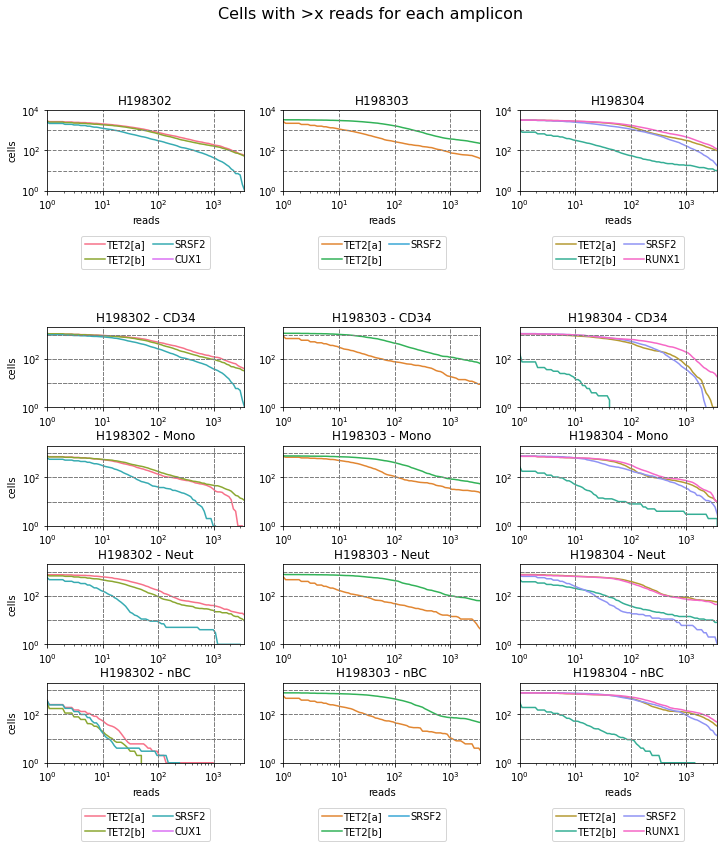

In [12]:
patients = ['PD7153', 'PD7151', 'JP001'] #reorder

#Create proxy artists for legend
JP001_labels = [ 'JP001_TET2a',  'JP001_TET2b_g', 'JP001_SRSF2', 'JP001_RUNX1_g']
JP001_handles = []
for lab in JP001_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    JP001_handles.append(line)
JP001_labels_r = [relabel.get(x) for x in JP001_labels]    

PD7153_labels = [ 'PD7153_TET2a', 'PD7153_TET2b','PD7153_SRSF2', 'PD7153_CUX1']
PD7153_handles = []
for lab in PD7153_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    PD7153_handles.append(line)
PD7153_labels_r = [relabel.get(x) for x in PD7153_labels]  

PD7151_labels = ['PD7151_TET2a', 'PD7151_TET2b', 'PD7151_SRSF2']
PD7151_handles = []
for lab in PD7151_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    PD7151_handles.append(line)
PD7151_labels_r = [relabel.get(x) for x in PD7151_labels]  

#Plot amplicons for each patient on single plot by cell type - match colors to VAF plots

alt_id = ['H198302', 'H198303', 'H198304']
pt_label = dict(zip(patients, alt_id))

fig, ax = plt.subplots(6, 3, figsize = (12, 12), gridspec_kw = dict(height_ratios = [2,1.5, 2,2,2,2], hspace = 0.5)) 

ax = ax.ravel()


for i, p in enumerate(patients):
    plot_df = all_df[p].copy()
    c = plot_df.columns
    d = []
    for a in all_amps:
        if a not in c:
            continue
        else:
            x = np.logspace(0, 4, 100) 
            y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
            ax[i].plot(x, y, color = allVAFcols[a])
            if a != 'PD7153_CUX1':
                d.append(a)
    
    #Extra code plots cells with >x reads for all amplicons
    #allplot = plot_df[d]
    
    #x = np.logspace(0, 4, 100)     
    #y = [allplot.loc[(allplot >= xi).all(axis=1)].shape[0] for xi in x]
    #ax[i].plot(x, y, color = 'gray')
    
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    ax[i].set_xlim(1, 3500)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray') 
    label = pt_label[p]
    ax[i].set_title(f'{label}')  


for l, p in enumerate(patients):
    plot_df2 = all_df[p].copy()
    c = plot_df2.columns
    plot_df2['celltype'] = plot_df2.index.get_level_values(2)
    
    for k, ct in enumerate(ctypes):
        i = (k*3) + l + 6
        plot_df3 = plot_df2.loc[plot_df2['celltype'].isin([ct])]
        
        for a in all_amps:
            if a not in c:
                continue
            else:
                x = np.logspace(0, 4, 100) 
                y = [plot_df3.loc[(plot_df3[a] >= xi)].shape[0] for xi in x]
                ax[i].plot(x, y, color = allVAFcols[a])
        
                ax[i].set_yscale('log')
                ax[i].set_xscale('log')
                ax[i].set_ylim(1, 2000)
                ax[i].set_xlim(1, 3500)
                ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
                label = pt_label[p]
                ax[i].set_title(f'{label} - {ct}')  
                
ax[0].set_xlabel('reads') 
ax[1].set_xlabel('reads') 
ax[2].set_xlabel('reads') 
ax[15].set_xlabel('reads') 
ax[16].set_xlabel('reads') 
ax[17].set_xlabel('reads') 

ax[0].set_ylabel('cells') 
ax[6].set_ylabel('cells')
ax[9].set_ylabel('cells')
ax[12].set_ylabel('cells')
ax[15].set_ylabel('cells')

ax[3].remove()
ax[4].remove()
ax[5].remove()

ax[2].legend(handles = JP001_handles, labels = JP001_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[0].legend(handles = PD7153_handles, labels = PD7153_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[1].legend(handles = PD7151_handles, labels = PD7151_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)

ax[17].legend(handles = JP001_handles, labels = JP001_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[15].legend(handles = PD7153_handles, labels = PD7153_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[16].legend(handles = PD7151_handles, labels = PD7151_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)


fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1)     
#fig.tight_layout()  
fig.savefig('../Results/All_reads_per_amplicon.png',bbox_inches='tight', dpi = 600)
fig.savefig('../Results/All_reads_per_amplicon.svg',bbox_inches='tight', dpi = 600)